In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import os
import numpy as np
from scipy.special import expit as sigmoid
dir_path = os.getcwd()


# Exercise 1: Learning in discrete graphical models

Soit les observations $Y = (Y_1, ..., Y_n)$ avec 

$$
Y_i = 
 \bigg(
    \begin{array}{ll}
        X_i \\
        Z_i
    \end{array}
 \bigg)
$$

alors 
$$ p(y) = \prod_i p(y_i) = \prod_i p(x_i | z_i) p(z_i) = \prod_i \theta_{z_i x_i} \pi_{z_i} $$
$$ p(y) = \prod_{m \in \mathcal{M}} \pi_m^{n_m} \prod_{m \in \mathcal{M}, k \in \mathcal{K}} \theta_{mk}^{n_{mk}} $$ où 
$n_{mk} = \sum_i \mathbb{1}\{x_i = k, z_i = m\} =$ "Nombre de couples $(k, m)$ dans les observations"

et 

$n_m = \sum_i \sum_k n_{m, k} = \sum_i \mathbb{1}\{z_i = m\} =$ "Nombre d'observations où  $z_i = m$"

Alors, on veut maximiser
$$ log(p(y)) = \sum_m n_m log(\pi_m) + \sum_{m, k} n_{mk} log(\theta_{mk})$$
sous les contraintes 
$\sum_m \pi_m = 1$
et
$\sum_{m, k} \theta_{mk} = 1$

Posons donc le Lagrangien :

$$ \mathcal{L}(\pi, \theta, \lambda, \mu) =  \sum_m n_m log(\pi_m) + \sum_{m, k} n_{mk} log(\theta_{mk}) - \lambda(\sum_m \pi_m - 1) - \mu(\sum_{m, k} \theta_{mk} - 1)$$ 

En dérivant par rapport à $\pi$:
$$ \frac{\partial \mathcal{L}}{\partial \pi_m} = \frac{n_m}{\pi_m} - \lambda = 0  \Rightarrow \pi_m = \frac{n_m}{\lambda}$$ or avec la contrainte $$\sum_m \pi_m = 1 \Rightarrow \hat{\pi}_m = \frac{n_m}{n}$$

De même, en dérivant par rapport à $\theta$:
$$ \frac{\partial \mathcal{L}}{\partial \theta_{mk}} = \frac{n_{mk}}{\theta_{mk}} - \mu = 0  \Rightarrow \theta_{mk} = \frac{n_{mk}}{\mu}$$ or avec la contrainte $$\sum_{m, k} \theta_{mk} = 1 \Rightarrow \hat{\theta}_{mk} = \frac{n_{mk}}{n}$$

# Exercice 2 :  Linear classification

In [2]:
modelNames = ['A', 'B', 'C']
d_types = ['train', 'test']
data = dict()
for model in modelNames:
    for d_type in d_types:
        path = dir_path +"/"+"classification_data_HWK1/classification" +model +'.' + d_type 
        data[model+'_'+d_type] = pd.read_csv(path, sep='\t', header=None).values

### 1) Generative model: LDA

(a) Pour une seule observation :
$$ p(y|x) \propto p(x|y)p(y) = \pi^y (1-\pi)^{1-y} p(x|y)$$
$$ p(y|x) \propto \pi^y (1-\pi)^{1-y} (det(\Sigma))^{-n/2} exp(-\frac{y}{2}(x-\mu_1)^T \Sigma^{-1} (x-\mu_1) - \frac{1-y}{2}(x - \mu_0)^T \Sigma^{-1}(x-\mu_0)) $$

$$ p(y|x) \propto \pi^y (1-\pi)^{1-y} (det(\Sigma))^{-n/2} \ exp\big(y x^T \Sigma^{-1} (\mu_1 - \mu_0) + \frac{y}{2}(\mu_0^T \Sigma^{-1}\mu_0 - \mu_1^T \Sigma^{-1}\mu_1) -\frac{1}{2}(x - \mu_0)^T \Sigma^{-1}(x-\mu_0)\big) $$

Donc, pour n observations $(X_i, Y_i)$ iid, on a :

$$ log\big(p(y|x)\big) = log(\pi)\sum_i y_i + log(1-\pi)\sum_i(1- y_i) -\frac{n}{2}log\big(det(\Sigma)\big) + \sum_i y_i x_i^T\Sigma^{-1}(\mu_1 - \mu_0) + (\mu_0^T \Sigma^{-1}\mu_0 - \mu_1^T \Sigma^{-1}\mu_1)\sum_i \frac{y_i}{2} \\ -\frac{1}{2}\sum_i (x_i - \mu_0)^T \Sigma^{-1}(x_i-\mu_0) + Cste  $$

* Estimation de $\mu_0$:
$$
\nabla_{\mu_0}\Big(log\big(p(y|x)\big)\Big) = - \sum_i y_i x_i^T \Sigma^{-1} + 2 \mu_0^T \Sigma^{-1} \sum_i \frac{y_i}{2} + \sum_i (x_i-\mu_0)^T \Sigma^{-1} = 0 
$$

$$ \Leftrightarrow  \mu_0^T  \sum_i y_i + \sum_i x_i^T - \mu_0^T \sum_i 1  = \sum_i y_i x_i^T $$

$$ \Leftrightarrow  \mu_0^T  \sum_i (1-y_i) = \sum_i x_i^T(1-y_i)  $$
$$ \Leftrightarrow  \hat{\mu}_0 = \frac{\sum_i x_i^T(1-y_i)}{\sum_i (1-y_i)}  $$
donc l'estimateur du maximum de vraisemblance pour $\mu_0$ est la moyenne empirique des $x_i$ pour les observations où $y_i = 0$


* Estimation de $\mu_1$:
$$\nabla_{\mu_1}\Big(log\big(p(y|x)\big)\Big) = \sum_i y_i x_i^T \Sigma^{-1} - 2 \mu_1^T \Sigma^{-1} \sum_i \frac{y_i}{2}  = 0 $$
$$ \Leftrightarrow \sum_i y_i x_i = \mu_1 \sum_i y_i $$
$$ \Leftrightarrow  \hat{\mu}_1  = \frac{\sum_i y_i x_i}{\sum_i y_i} $$
donc l'estimateur du maximum de vraisemblance pour  $\mu_1$  est la moyenne empirique des $x_i$ pour les observations où $y_i=1$

* Estimation de $\pi$:
$$\nabla_\pi \Big(log\big(p(y|x)\big)\Big) = \frac{\sum_i y_i}{\pi} - \frac{\sum_i (1-y_i)}{1-\pi} = 0$$
$$\Leftrightarrow \hat{\pi} = \frac{\sum_i y_i}{n}  $$
donc l'estimateur du maximum de vraisemblance de $\pi$ est la moyenne empirique des $y_i$


* Estimation de $\Sigma$:

En posant $\Lambda = \Sigma^{-1}$ on peut réecrire, en ne gardant que les termes dépendant de $\Lambda$:
$$
log\big(p(y|x)\big) = \frac{n}{2}log\big(det(\Lambda)\big) + \sum_i tr\big(y_i x_i^T\Lambda(\mu_1 - \mu_0)\big) + \big(tr(\mu_0^T \Lambda \mu_0) - tr(\mu_1^T \Lambda\mu_1)\big)\sum_i \frac{y_i}{2} -\frac{1}{2}\sum_i tr \big( (x_i - \mu_0)^T \Lambda(x_i-\mu_0)\big) + Cste
$$
$$
= \frac{n}{2}log\big(det(\Lambda)\big) + tr\big(\Lambda \sum_i y_i x_i(\mu_1 - \mu_0)^T\big) + \big(tr(\Lambda \ \mu_0 \mu_0^T) - tr(\Lambda \mu_1 \mu_1^T)\big)\sum_i \frac{y_i}{2} 
-\frac{1}{2} tr \big(  \Lambda \sum_i (x_i - \mu_0)(x_i-\mu_0)^T\big) + Cste
$$
or, pour A, B deux matrices carrées $\nabla_A tr(AB) = B^T$, et $\nabla_A\Big(log\big(det(A)\big)\Big) = A^{-1}$
d'où
$$
\nabla_\Lambda \Big(log\big(p(y|x)\big)\Big) = \frac{n}{2} \Sigma
+ \sum_i y_i x_i^T(\mu_1 - \mu_0)
+ (\mu_0^T \mu_0 - \mu_1^T \mu_1)\sum_i \frac{y_i}{2}
-\frac{1}{2} \sum_i (x_i - \mu_0)^T(x_i-\mu_0) = 0
$$
$$
\Leftrightarrow \Sigma = \frac{1}{n} \big(
\sum_i y_i \big( -2 x_i^T\mu_1 + \mu_1^T \mu_1 + x_i^T x_i - x_i^T x_i\big)
+ \sum_i y_i \big( 2 x_i^T\mu_0 - \mu_0^T \mu_0 + x_i^T x_i - x_i^T x_i \big)
+ \sum_i (x_i - \mu_0)^T(x_i-\mu_0) \big)
$$
$$
\Leftrightarrow \Sigma = \frac{1}{n} \big(
\sum_i y_i (x_i - \mu_1)^T(x_i - \mu_1)
- \sum_i y_i (x_i - \mu_0)^T(x_i - \mu_0)
+ \sum_i (x_i - \mu_0)^T(x_i-\mu_0) \big)
$$
$$
\Leftrightarrow \hat\Sigma = \frac{1}{n} \big(
\sum_i y_i (x_i - \mu_1)^T(x_i - \mu_1)
+ \sum_i (1-y_i) (x_i - \mu_0)^T(x_i-\mu_0) \big)
$$

* Calul de $p(y = 1|x)$:
$$
p(y = 1|x) = \frac{p(x|y=1)p(y=1)}{p(x|y=1)p(y=1) + p(x|y=0)p(y=0)} = \frac{1}{1+\frac{p(x|y=1)p(y=1)}{p(x|y=0)p(y=0)}}
$$
$$
p(y = 1|x) = \frac{1}{1+\frac{\pi}{1-\pi}exp\big( +\frac{1}{2}(x-\mu_0)^T\Sigma^{-1}(x-\mu_0) - \frac{1}{2}(x-\mu_1)^T\Sigma^{-1}(x-\mu_1) \big)}
$$
$$
p(y = 1|x) = \frac{1}{1+exp\big( x^T\Sigma^{-1}(\mu_1-\mu_0) + \frac{1}{2}(\mu_0^T\Sigma^{-1}\mu_0 - \mu_1^T\Sigma^{-1}\mu_1) + log(\frac{\pi}{1-\pi})\big)} = \sigma\big( a^T x + b \big)
$$
avec $a = (\mu_0-\mu_1)^T\Sigma^{-1} $ et $b = \frac{1}{2}(\mu_1^T\Sigma^{-1}\mu_1 - \mu_0^T\Sigma^{-1}\mu_0) - log(\frac{\pi}{1-\pi})$

In [3]:
from numpy.linalg import inv

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def plotLDAForModel(modelName): 
    fig, ax = plt.subplots()
    
    dataForModel = data[modelName+ '_train']
    
    # x0 est l'ensemble des xi pour lesquels yi = 0
    x0 = dataForModel[:, 0:2][dataForModel[:, 2]==0]
    mu0 = np.mean(x0, axis=0)
    
    # x1 est l'ensemble des xi pour lesquels yi = 1
    x1 = dataForModel[:, 0:2][dataForModel[:, 2]==1]
    mu1 = np.mean(x1, axis=0)
    
    pi = np.mean(dataForModel[:, 2])

    sigma = (np.dot((x0 - mu0).T, x0 - mu0) + np.dot((x1 - mu1).T, x1 - mu1))/dataForModel.shape[0]
    sigmainv = inv(sigma)

    a = np.dot((mu0 - mu1).T, sigmainv)
    b = 1/2 * (- np.dot(mu0.T, np.dot(sigmainv, mu0)) + np.dot(mu1.T, np.dot(sigmainv, mu1)) ) - np.log(pi/(1-pi))

    x0min = np.min(dataForModel[:, 0])
    x0max = np.max(dataForModel[:, 0])
    
    xx0 = np.arange(x0min, x0max, (x0max-x0min)/100)
    xx1 = -a[0]/a[1]*xx0 - b/a[1]
    ax.plot(xx0, xx1)
    
    x_abs = dataForModel[:, 0]
    x_ord = dataForModel[:, 1]
    y = dataForModel[:, 2]
    ax.scatter(x_abs, x_ord, c = y)
    
    
    title = "LDA Data plot for Model "+modelName
    plt.title(title)
    plt.xlabel('x0')
    plt.ylabel('x1')

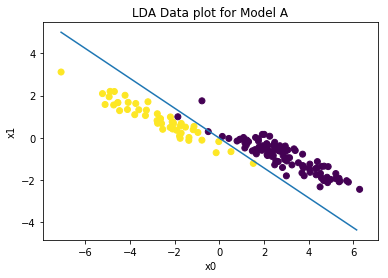

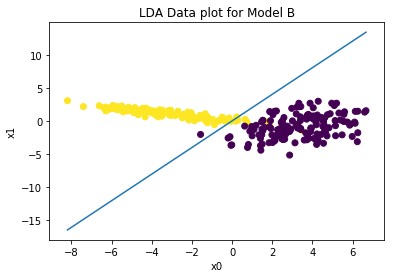

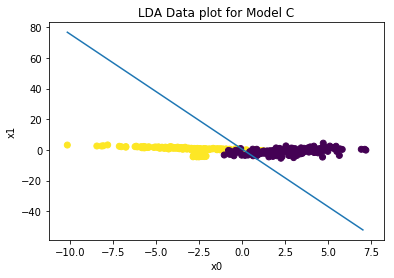

In [4]:
for name in modelNames:
    plotLDAForModel(name)

### 2) Logistic Regression

f is of the form $ f(x) = w^TX + b . \ $ <br>
We can augment X with a row of 1 to remove b of the Equation. <br>
f thus become $ f(x) = w^T\tilde{X} $ <br>
with $\tilde{X} = (X, 1)$

We will need to solve the Modified normal equations using the Newton's method described in the class material


Then if we want to plot $ p(y = 1|x) = 0.5 $ we need to solve the equation $$  \frac{\mathrm{1} }{\mathrm{1} + e^-f(x) } = 0.5  $$ which is equivalent to solving $ f(x) = 0 $ 

We thus need to represent the line of equation $ x_2 = \frac{- b - w_1*x_1}{w_2} $


In [5]:
w0init = dict()
w0init['A'] = np.array([[0.7705846734165602], [0.5281598619924476], [0.41861207653102495]])
w0init['B'] = np.array([[0.2237963501074024], [0.03727566587354736], [0.5629049044816309]])
w0init['C'] = np.array([[0.12116464647012481], [0.2976639368542129], [0.5205404651440133]])



In [692]:
def getLogRegParametersForModel(modelName):
    Y = np.copy(data[modelName +'_train'][:, 2:3])
    X = np.copy(data[modelName + '_train'][:, 0:3])
    
    # we replace the third row by the augmented row
    X[:, 2] = 1
    X_t = np.transpose(X)
    
    w = w0init[modelName]
    eta = np.transpose(sigmoid(np.dot(np.transpose(w), X_t)))
    etaa = eta*(1-eta)
    D = np.diag(etaa[:, 0])
    Y_tilde = Y - eta
    
    for t in range(10000):   
        inv = np.linalg.inv(np.dot(np.dot(X_t, D), X))
        first = np.dot(inv, X_t)
        second = np.dot(first, Y_tilde)
        w = w + second

        eta = np.transpose(sigmoid(np.dot(np.transpose(w), X_t)))
        etaa = eta*(1-eta)
        D0 = np.diag(etaa[:,0])
        Y_tilde = Y - eta
        
    return w


In [693]:
def LogReg_proba_lim(x1,w1,w2,b):
    return -1/w2 * (w1 * x1 + b)

def plotLogRegForModel(modelName): 
    fig, ax = plt.subplots()
    
    dataForModel = data[modelName+ '_train']  
    x_abs = dataForModel[:, 0]
    x_ord = dataForModel[:, 1]
    y = dataForModel[:, 2]
    ax.scatter(x_abs, x_ord, c = y)
    
    x0min = np.min(dataForModel[:, 0])
    lowerBound = int(x0min)
    x0max = np.max(dataForModel[:, 0])
    upperBound = int(x0max) + 1
    
    w = getLogRegParametersForModel(modelName)
    plt.plot(range(lowerBound, upperBound), [LogReg_proba_lim(i,w[0],w[1],w[2]) for i in range(lowerBound, upperBound)])
    
    title = "Log Reg Data plot for Model "+modelName
    plt.title(title)
    plt.xlabel('x0')
    plt.ylabel('x1')

In [694]:
# for i in range (100):
#     if i % 100 == 0:
#         print(i)
#     try:
#         w0 = IRLS('C', i)
#         plotLogRegForModel('C', w0)
#     except:
#         pass
# todo remove

In [710]:
def printLogRegParametersForModel(modelName):
    w = getLogRegParametersForModel(modelName)
    print('For Logistic regression of model {0} learnt parameters are :\n\tw = [{1:.3f},{2:.3f}]\n\tb = {3:.3f}\n'.format(modelName,
                                                                                                w[0][0],
                                                                                                w[1][0],
                                                                                                w[2][0]))

In [711]:
for name in modelNames:
    printLogRegParametersForModel(name)

For Log reg model A learnt parameters are :
	w = [-27.798,-47.358]
	b = -5.142

For Log reg model B learnt parameters are :
	w = [-1.705,1.024]
	b = 1.350

For Log reg model C learnt parameters are :
	w = [-2.203,0.709]
	b = 0.959



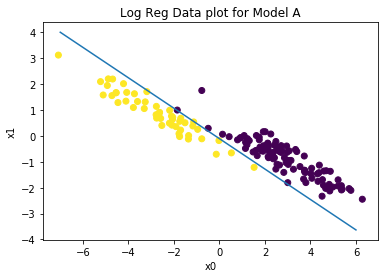

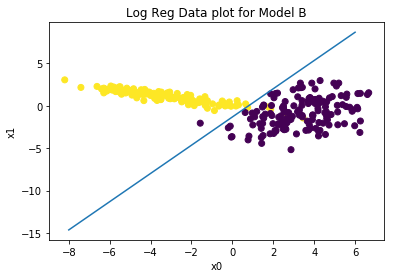

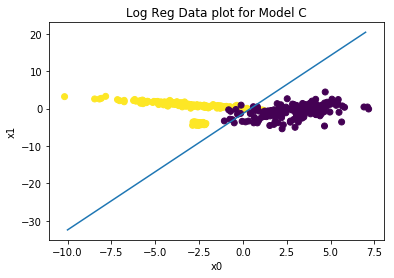

In [697]:
for name in modelNames:
    plotLogRegForModel(name)

### 3) Linear Regression

f is of the form $ f(x) = w^Tx + b . \ $ <br>
We can augment X with a row of 1 to remove b of the Equation. <br>
f thus become $ f(x) = \tilde{w}^T\tilde{x} $ <br>
with $\tilde{x} = (x, 1) $ and $\tilde{w} = (w, b) $

We need to solve the normal equation which is : $$ \tilde{X}^T\tilde{X}\tilde{w}-\tilde{X}^Ty=0 $$

Also we want to plot $ p(y = 1|x) = 0.5 $ <br>
According to our model, $$ p(y|x) = \mathcal{N}((w^Tx + b), \sigma^2) $$ <br>
thus if we want to plot $$ p(y = 1|x) = 0.5 $$ 
we need to solve <br> $$ p(y = 1|x) = p(y = 1|x) = \frac{\mathrm{1} }{ \sqrt{2\pi \sigma^2}}e^{-\frac{(1 - (w^Tx + b))^2}{2\sigma^2}} = 0.5 $$ <br>
This leads to: 
$$x_1 = \frac{1}{w_1}[-w_0x_0 - b + 1 + \sqrt{\sigma^2\ln(\frac{2}{\pi\sigma^2})}\ ]$$

$$or$$

$$x_1 = \frac{1}{w_1}[-w_0x_0 - b + 1 - \sqrt{\sigma^2\ln(\frac{2}{\pi\sigma^2})}\ ]$$

with the condition $$ \sigma^2 \leqslant \frac{2}{\pi} $$

Note that we can estimate $ \sigma $ with the data. Indeed $$ \tilde{\sigma} = \frac{1}{n} || Y - \tilde{w}^T\tilde{X} ||^2 $$

In [783]:
def getLinRegParametersForModel(modelName):
    Y = np.copy(data[modelName +'_train'][:, 2:3])
    X = np.copy(data[modelName + '_train'][:, 0:3])
    # we replace the third row by the augmented row
    X[:, 2] = 1
    
    rank = np.linalg.matrix_rank(X)
    if rank != 3:
        print("XtX isn't invertible")
    X_t = np.transpose(X)
    w = np.dot(np.linalg.inv(np.dot(X_t, X)), np.dot(X_t, Y))
    
    est = np.dot(np.transpose(w), X_t)[0]
    gap = Y[:, 0] - est
    sigma = np.sqrt((np.sum((gap*gap))/len(Y)))
    
    return w[0][0], w[1][0], w[2][0], sigma
    

In [777]:
def printLinRegParametersForModel(modelName):
    omega0, omega1, b, sigma = getLinRegParametersForModel(name)
    print('For linear regression of model {0} learnt parameters are :\n\tw = [{1:.3f},{2:.3f}]\n\tb = {3:.3f}\n\tsigma {4:.3f}'.format(name,omega0,omega1,b,sigma))

In [778]:
for name in modelNames:
    printLinRegParametersForModel(name)

For linear regression of model A learnt parameters are :
	w = [-0.264,-0.373]
	b = 0.492
	sigma 0.200
For linear regression of model B learnt parameters are :
	w = [-0.104,0.052]
	b = 0.500
	sigma 0.233
For linear regression of model C learnt parameters are :
	w = [-0.128,-0.017]
	b = 0.508
	sigma 0.249


In [800]:
def LinReg_proba_lim_0(x0,w0,w1,b, sigma):
    sigmaSquare = sigma*sigma
    return 1/w1 * (1 - w0 * x0 - b - np.sqrt(sigmaSquare*np.log(2 / (np.pi*sigmaSquare))))

def LinReg_proba_lim_1(x0,w0,w1,b, sigma):
    sigmaSquare = sigma*sigma
    return 1/w1 * (1- w0 * x0 - b + np.sqrt(sigmaSquare*np.log(2 / (np.pi*sigmaSquare))))

def plotLinRegForModel(modelName): 
    fig, ax = plt.subplots()
    
    dataForModel = data[modelName+ '_train']  
    x_abs = dataForModel[:, 0]
    x_ord = dataForModel[:, 1]
    y = dataForModel[:, 2]
    ax.scatter(x_abs, x_ord, c = y)

  
    x0min = np.min(dataForModel[:, 0])
    lowerBound = int(x0min)
    x0max = np.max(dataForModel[:, 0])
    upperBound = int(x0max) + 1
    
    omega0, omega1, b, sigma = getLinRegParametersForModel(name)
    plt.plot(range(lowerBound, upperBound), [LinReg_proba_lim_0(i,omega0, omega1, b, sigma) for i in range(lowerBound, upperBound)])
    plt.plot(range(lowerBound, upperBound), [LinReg_proba_lim_1(i,omega0, omega1, b, sigma) for i in range(lowerBound, upperBound)],color = 'red')
    
    title = "Lin Reg Data plot for Model "+modelName
    plt.title(title)
    plt.xlabel('x0')
    plt.ylabel('x1')

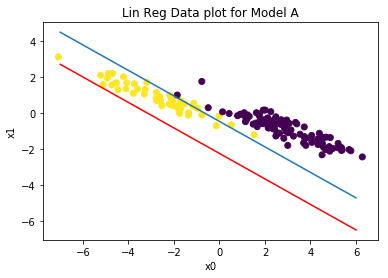

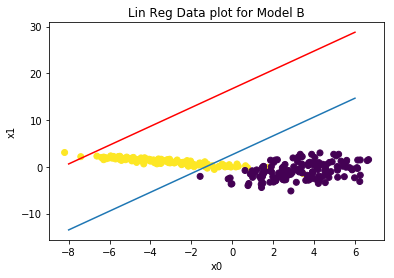

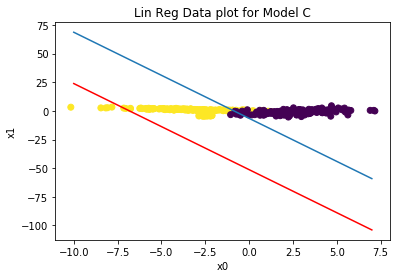

In [801]:
for name in modelNames:
    plotLinRegForModel(name)
   

### 4) Errors

#### a)

In [703]:
#def computeLDAErrorsForModel(modelName):
    

In [704]:
def computeLogRegErrorsForModel(modelName, dataSource):
    w0, w1, b = getLogRegParametersForModel(modelName)
    
    def logFunc(x0, x1):
        value = w0 * x0 + w1 * x1 + b
        return sigmoid(value)
    
    X = np.copy(data[modelName + '_' + dataSource][:, 0:2])
    Y = np.copy(data[modelName + '_' + dataSource][:, 2:3])
    
    numMissclassified = 0 
    for i in range(len(X)):
        val = logFunc(X[i][0], X[i][1])
        valPredict = 0
        if val >= 0.5:
            valPredict = 1
        if valPredict != Y[i]:
            numMissclassified +=1
    
    return numMissclassified/len(X)
        

In [841]:
def printLogRegParametersForModel(modelName):
    d_types = ['train', 'test']
    for t in d_types:
        err = computeLogRegErrorsForModel(modelName, t) * 100
        print('For {0} data of model {1} the error rateof log reg is {2:.2f} %'.format(t,modelName,err))

In [842]:
for name in modelNames:
    printLogRegParametersForModel(name)

For train data of model A the error rateof log reg is 0.00 %
For test data of model A the error rateof log reg is 3.53 %
For train data of model B the error rateof log reg is 2.00 %
For test data of model B the error rateof log reg is 4.30 %
For train data of model C the error rateof log reg is 4.00 %
For test data of model C the error rateof log reg is 2.27 %


In [876]:
def computeLinRegErrorsForModel(modelName, dataSource):
    w0, w1, b, sigma = getLinRegParametersForModel(name)
    sigmaSquare = sigma*sigma
    
    def logFunc1(x0, x1):
        intermediateValue = (1 - w0 * x0 - w1 * x1 - b)**2 / (2 * sigmaSquare)
        value = np.exp(-intermediateValue)/np.sqrt(2*np.pi*sigmaSquare)
        return value
    def logFunc0(x0, x1):
        intermediateValue = (0 - w0 * x0 - w1 * x1 - b)**2 / (2 * sigmaSquare)
        value = np.exp(-intermediateValue)/np.sqrt(2*np.pi*sigmaSquare)
        return value
    
    X = np.copy(data[modelName + '_' + dataSource][:, 0:2])
    Y = np.copy(data[modelName + '_' + dataSource][:, 2:3])
    
    numMissclassified = 0 
    for i in range(len(X)):
        val0 = logFunc0(X[i][0], X[i][1])
        val1 = logFunc1(X[i][0], X[i][1])
        
        valPredict = 0
        if val1 > val0:
            valPredict = 1
        if valPredict != Y[i]:
            numMissclassified +=1
    
    return numMissclassified/len(X)

In [877]:
def printLinRegParametersForModel(modelName):
    d_types = ['train', 'test']
    for t in d_types:
        err = computeLinRegErrorsForModel(modelName, t) * 100
        print('For {0} data of model {1} the error rate of lin reg is {2:.3f} %'.format(t,modelName,err))

In [878]:
for name in modelNames:
    printLinRegParametersForModel(name)

2.4635924199656133e-05 1.9347719631349434
0.0002066797605666228 1.5369800156530016
0.003994261115303977 0.6655511551777963
0.0086155621983398 0.4646509410979353
0.022142581282429765 0.2663151946940792
0.00074116372540033 1.1711424384659233
0.00016679877098897003 1.591412516355513
0.00018600872813467675 1.564061223182347
0.0006632649516413661 1.2048667770941215
0.0006469826318603332 1.2123863473229834
3.6889235293918016e-08 1.2610572615222433
0.0012193786338545152 1.0184672961766457
1.1700647209827083e-06 1.8800664024272828
4.517362020987625e-05 1.8567545850089002
8.001857436602003e-07 1.8298582199948603
0.036148754045389836 0.18739160145067696
2.8256821029879952e-05 1.919818041225689
1.7733898047430604e-05 1.9641338418264984
9.200512931151696e-07 1.849133741148442
5.3967722756974945e-09 0.8883556432435662
1.6599647232670164e-05 1.968930933097884
2.8304579744451304e-08 1.2074904873706611
0.0012826036804219302 1.0029373379288027
0.002078091598341698 0.8559634828598932
8.992728093501687e-

0.9832601619010963 0.0013675258112340678
1.4275863411954834 8.394699624082466e-08
1.4490838181588652 0.0002868170662403246
1.922346743943742 2.7636404958937302e-05
1.9888721065201456 1.1497308459619089e-05
1.2184176512800295 2.9880072151196185e-08
1.942292630026173 2.285233693353895e-05
1.6813517955501944 0.00011391487428017447
1.9459961676004578 2.199142274586386e-06
1.8109669632057563 5.963079434267347e-05
1.9044703538320664 1.4420672039064376e-06
0.2620167314221199 3.862904970389239e-11
0.13182821597266292 3.992404338378552e-12
1.52393919975372 0.00021725963175941407
1.992500349143624 1.0350722089212128e-05
1.997773574672687 6.544729909790604e-06
0.815916562826933 0.002375735494126201
1.391517445095173 0.00035215507075312064
1.8365530907650387 5.12979909234905e-05
1.1138307207818658 0.0008940031070664524
1.9969472843005587 6.030403206690834e-06
0.3581931848514943 1.1862726731541846e-10
1.893954966957942 3.483263340991272e-05
0.1626817283981927 7.810652902093984e-12
0.151257468969301

1.6111629760111044 2.1530955329900772e-07
1.7022871641217856 3.5709943617059345e-07
1.9410779758290257 2.078509913772132e-06
0.25252506984547696 3.3982276296657177e-11
0.9711362673864063 0.001422691379305615
1.491839008977574 1.15877789998345e-07
0.7054539670299064 0.0034685544404919355
0.5931337195455224 0.005202138692141353
1.9967334021898377 8.570179226137015e-06
1.9944377953732462 9.640389806368984e-06
1.4620031569931586 0.00027365602822031096
1.7643705587279301 7.664810659909425e-05
1.5953982511096876 0.00016413149053638598
1.9206453578653528 2.805344410460614e-05
1.9967700715954624 5.953444089828671e-06
1.9872468221986381 4.212311001039636e-06
For test data of model A the error rate of lin reg is 2.067 %
0.006107010442076215 1.1057949219354932
3.492470841079403e-06 1.217252550592429
0.0054141212057233915 1.1425929029180886
0.0018923610569552907 1.4280173941915675
0.3575035290467588 0.07106996855228732
0.005680477860493549 1.1279924068182536
0.005472705646452992 1.1393297599473875

0.21132175880833998 0.13712536128003225
0.006764538407510682 1.0740950651667622
0.0014858041299914515 1.481933171502754
0.2576560445342639 0.1091556916458428
0.0002507671670136846 1.7055633983738483
0.8588227669892052 0.01326370930251994
0.0014621476324621035 1.485328691668377
0.3241427910918211 0.08142454009687984
0.02132805927510724 0.706106707978398
0.0050138147951198225 1.1657268251263397
0.0010010295330319667 1.5585682191336225
0.0063319649555558305 1.0946258039852055
6.320882765691968e-05 1.669646197155627
0.0020020941102557384 1.4147337632837949
4.1422935790804605e-05 1.6281743927586572
0.07525428000964314 0.3432858217421261
6.265700597785389e-05 1.6689131063756526
0.04914235587238987 0.45523029759136463
0.001340610059865626 1.5032841311627723
0.009281165397868954 0.9739838342123078
0.0027864098599302504 1.3317405979847667
0.00023348861379586693 1.7079424789636652
0.009495346024704162 0.9666709755923769
0.005630739210313182 1.130673720471386
9.777263933609988e-06 1.4121487303766

1.3482893140726242 6.8972896522511565e-06
0.5603441219514654 0.03416740872934359
0.1743395380412495 0.16789613078589113
1.5327080838316682 0.0011537103177707332
0.7292562353350821 0.019831810603563663
0.9925628022827586 0.008757258931701711
1.0368768242360917 0.007616360444122098
0.5440360200466804 0.03608961129511925
1.3564915092958774 0.002533478309797886
1.5598697936052621 0.0009936117436613082
1.6580513395103125 5.541070940505641e-05
1.5734823681492769 2.677791505575107e-05
1.6883890617510735 8.15166451427691e-05
0.6666397000657228 0.024169087855296888
1.0656757426649923 0.006949371680864829
1.686679343334856 7.939687217347202e-05
1.5740662041652 0.0009142718560152602
1.222226354914277 0.004138291472070348
0.6119457834026839 0.02882325824379028
1.0338691600979695 0.007689253615327073
1.2368129698406094 0.003933727250641846
1.0744340744524417 0.0067571885305349935
1.7108836363310818 0.00014068845836184168
0.5409609413474057 0.03646615471720106
0.15929374280107952 0.18356808897161658

0.02325161899075551 0.873961654196919
0.0712381720609011 0.5085829707913289
0.020956436404665695 0.9081767211072092
0.028587134064687957 0.8054602462204433
2.6953340087719184e-05 1.268548534032043
0.013205766021359344 1.0561177683656067
0.00361309129251214 1.398718154240524
5.774961998463822e-05 1.400404928271083
3.3045806346592364e-08 0.24313296064493023
0.24560970137647853 0.18674574261430893
0.6933051047527421 0.04007885855524163
1.4030201894852711e-06 0.7108470092287548
0.002936160010011456 1.439516035127638
0.005344072846106262 1.3100806771856024
0.002324273075199152 1.4800587684264965
0.06184394043508547 0.5527536661022429
0.08727541241705492 0.44716225778416546
0.0003324862979412559 1.5893595302362271
0.2554206971229199 0.17899980217653313
0.012158341360039413 1.0816024512753608
0.00031443826615746353 1.5868544815075214
0.0009555420506547349 1.5798582114788067
0.0177944057583835 0.9614704171168839
6.198772472382615e-05 1.4115885532036843
0.3391791550487561 0.12807152148442447
0.

0.776200342335578 0.03121610998120866
0.7840651378718739 0.030486640161772532
1.5508143777780046 0.001357449576720414
0.2231070820229124 0.20646671210480852
0.9999876530099651 0.015783111552427148
0.5727609605355191 0.05806503284723236
0.6341815714074337 0.04799317794995082
1.5988553922416429 0.0005449877504801895
0.9162210892221758 4.332328699810006e-06
1.5143357198625018 0.0018449215519378986
0.07563871195871301 0.49018813702489544
0.48857566319912216 0.07603968050263152
0.8092938956154302 0.02825938574994823
0.36600673418579466 0.11596370534955697
0.81574357799695 0.027716315841520532
1.5099002470905736 0.0019053839611632912
1.429344329203998 0.003098766407621328
0.31906197856920226 0.13827720612158373
0.5356502035806942 4.6369500337420844e-07
1.1499926236773832 0.00967516708597313
1.368213281765128 4.742599158817462e-05
1.5959976719038638 0.00040600255805938406
0.5690560490530635 0.05874448267904897
0.3761754979945074 0.11176747903514231
1.2574123473198007 0.0065750338647412605
0.7

0.0036345466486613176 1.3974891269355947
0.0018068594307168414 1.5171423660933723
0.002752225330721657 1.4513211941912416
0.0025686560914072324 1.4634280492033709
0.0028991644163327626 1.4418646501542123
0.0020376582319718015 1.500303031524527
0.00185178550579865 1.5138307424217197
0.00297668387884448 1.4369581669566727
0.0014435913463103104 1.5443312599750545
0.00280856458644385 1.447670983241376
0.0021072435298654774 1.495316709874206
0.0016052739967093621 1.532163690443541
0.0022915276303404693 1.4823317408123353
0.0023076107177678095 1.4812140497923565
0.003677814383784096 1.395021935716947
0.0014177199481352975 1.5462800995086978
0.0036350340355420646 1.397461251304571
0.0032851685694111374 1.417979759139262
0.0013204317664030764 1.5535919498992163
0.0030227808710979807 1.4340671173021473
0.002897951600634251 1.4419418624351459
0.0015894724306035248 1.5333499926276932
0.0032976594136456846 1.4172292349458124
0.004039071132418997 1.3749935585717388
0.002590081148794534 1.4619980491